# Data Preprocessing

## Importing libraries

In [49]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

## Loading datasets

In [50]:
# Load the datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

## Merging datasets

In [51]:
# Merge datasets on customer ID
data = pd.merge(customers, transactions, on='CustomerID')

## Feature engineering

In [52]:
# Feature engineering
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])
data['SignupDate'] = pd.to_datetime(data['SignupDate'])
data['DaysSinceSignup'] = (data['TransactionDate'] - data['SignupDate']).dt.days

## Data Aggregation

In [53]:
# Aggregate data for clustering
agg_data = data.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'TotalValue': 'sum',
    'DaysSinceSignup': 'mean'
}).reset_index()

## Data standardization

In [54]:
# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(agg_data[['Quantity', 'TotalValue', 'DaysSinceSignup']])

# Clustering and plotting

In [55]:
# Determine the optimal number of clusters using the elbow method
inertia = []
silhouette_scores = []

for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))

<ipython-input-56-f5f41394c87a>:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


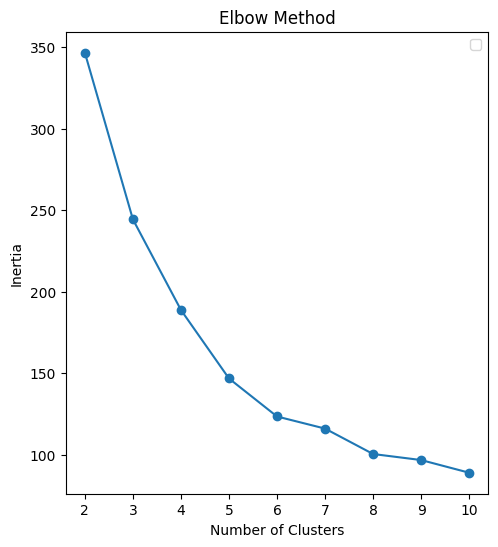

In [56]:
# Plot the elbow method
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.legend()

<ipython-input-57-09a475c61c19>:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


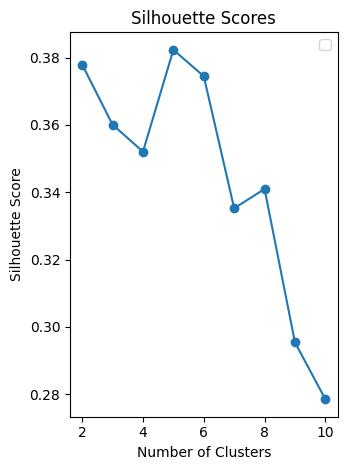

In [57]:
# Plot silhouette scores
plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.legend()
plt.tight_layout()
plt.show()

In [58]:
# Select the optimal number of clusters based on silhouette score
optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
print(f"Optimal Number of Clusters: {optimal_clusters}")

Optimal Number of Clusters: 5


In [60]:
# Fit K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
agg_data['Cluster'] = kmeans.fit_predict(scaled_features)

In [61]:
# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(scaled_features, agg_data['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")

Davies-Bouldin Index: 0.8726285876698137


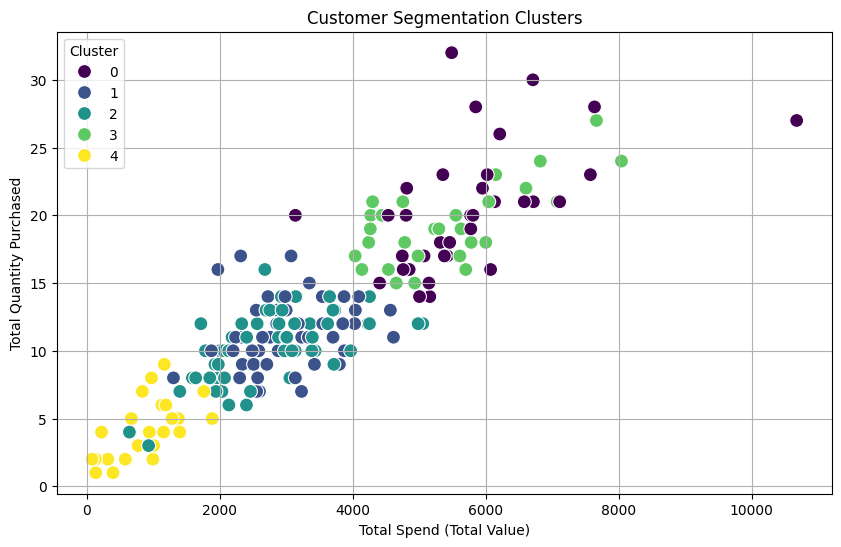

In [62]:
# Visualize Clusters in 2D using TotalValue and Quantity
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=agg_data,
    x='TotalValue',
    y='Quantity',
    hue='Cluster',
    palette='viridis',
    s=100
)
plt.title('Customer Segmentation Clusters')
plt.xlabel('Total Spend (Total Value)')
plt.ylabel('Total Quantity Purchased')
plt.legend(title='Cluster')
plt.grid()
plt.show()

In [63]:
# Summarize Cluster Characteristics
cluster_summary = agg_data.groupby('Cluster').agg(
    AvgSpend=('TotalValue', 'mean'),
    AvgQuantity=('Quantity', 'mean'),
    AvgDaysSinceSignup=('DaysSinceSignup', 'mean'),
    CustomerCount=('CustomerID', 'count')
).reset_index()

print("\nCluster Summary:")
print(cluster_summary)


Cluster Summary:
   Cluster     AvgSpend  AvgQuantity  AvgDaysSinceSignup  CustomerCount
0        0  5747.741765    20.500000          617.809375             34
1        1  3027.495000    11.203704           51.152998             54
2        2  2712.568750    10.232143          668.689073             56
3        3  5390.642069    19.206897           14.081117             29
4        4   879.043846     4.038462          220.990385             26


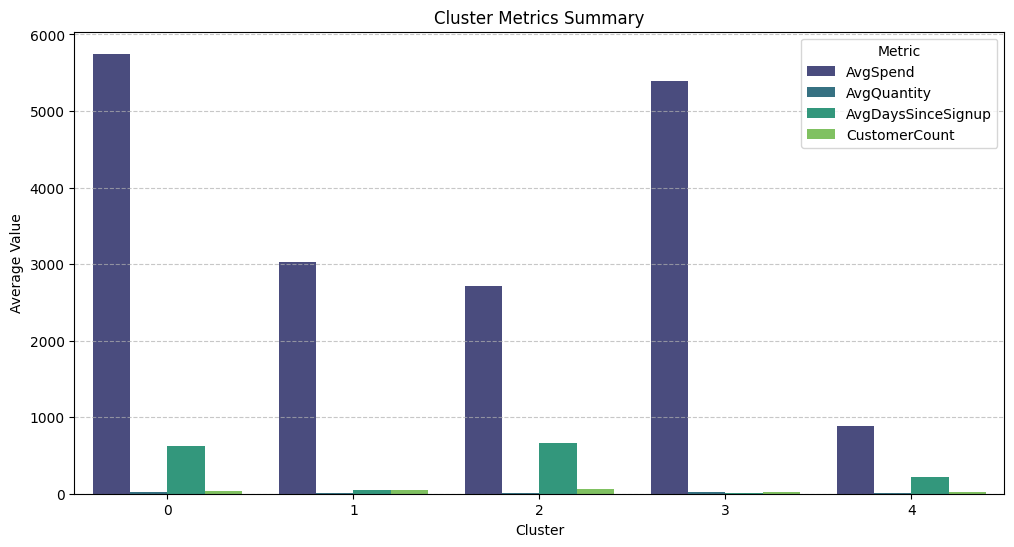

In [64]:
# Visualize Cluster Summary
cluster_summary_melted = cluster_summary.melt(id_vars='Cluster', var_name='Metric', value_name='Value')
plt.figure(figsize=(12, 6))
sns.barplot(data=cluster_summary_melted, x='Cluster', y='Value', hue='Metric', palette='viridis')
plt.title('Cluster Metrics Summary')
plt.ylabel('Average Value')
plt.xlabel('Cluster')
plt.legend(title='Metric')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()